In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_graph(arr, delimeter=93, ylabel='L2 hitrate', xlabel='kernels (in-order)'):
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(111)
    plt.tight_layout()
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.axvline(x=delimeter, color='r', linestyle='--')
    ax.plot(arr)

In [3]:
def plot_bar(arr, delimeter=93, ylabel='L1-L2 hitrate', xlabel='kernels (in-order)'):
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(111)
    plt.tight_layout()
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.axvline(x=delimeter, color='r', linestyle='--')
    ax.bar(list(range(len(arr))), height=arr, width=1)

In [4]:
#model = 'resnet50'
#model = 'resnet152'
model = 'vgg16'

In [5]:
onegpu = pd.read_csv('./src/'+model+'/nvprof_onegpu_entire.csv')
onegpu = onegpu.drop(0)


In [6]:
onegpu = onegpu.drop(index = list(range(94,128)))

In [7]:
onegpu = onegpu.reset_index()

In [8]:
# L1-L2 read hit rate -- l2_tex_read_hit_rate

# L1-L2 read transactions  -- l2_tex_read_transactions

# L1 hit rate -- tex_cache_hit_rate

# L1 transactions -- tex_cache_transactions

In [37]:
trans = onegpu['l2_tex_read_transactions'].astype(float).to_numpy()
hitrates = onegpu['l2_tex_read_hit_rate'].astype(float).to_numpy()
durations = onegpu['Duration'].astype(float).to_numpy()

In [38]:
def exclusive_scan(arr):
    scan = np.zeros_like(arr)
    for i in range(len(arr)):
        s = 0
        for j in range(i):
            s+=arr[j]
        scan[i] = s
    return scan

In [39]:
def create_timearray(durations, arr, timestep=0.001, delimeter = 93):
    durations = np.trunc(durations/timestep).astype(np.int32)
    total_time = sum(durations)
    start_times = exclusive_scan(durations)
    output = np.zeros(total_time)
    for i in range(len(durations)):
        output[start_times[i]:start_times[i]+durations[i]] = arr[i]
    return output, start_times[delimeter]

In [40]:
def get_global_averages(arr, delimeter):
    f = arr[:delimeter]
    b = arr[delimeter:]

    f = f[np.logical_not(np.isnan(f))]
    b = b[np.logical_not(np.isnan(b))]

    print("Average for forward is {}".format(f.mean()))
    print("Average for backward is {}".format(b.mean()))

In [41]:
hitrates_time, delimeter = create_timearray(durations, hitrates)

In [42]:
trans_time, delimeter = create_timearray(durations, trans)

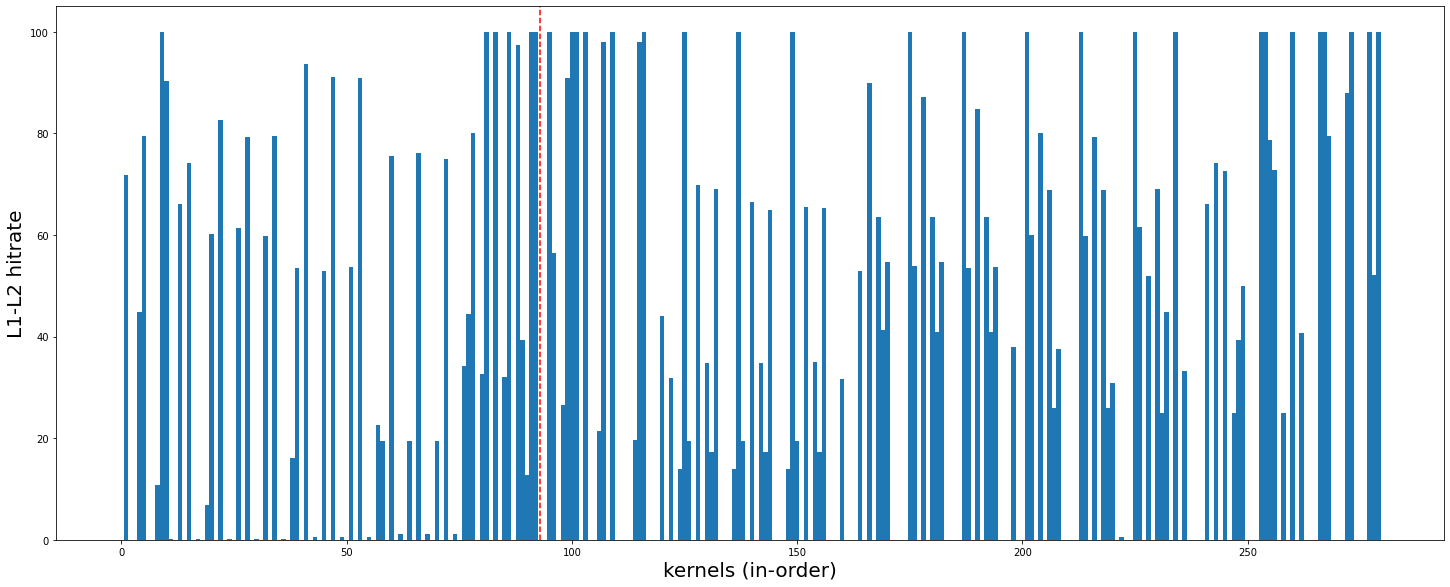

In [15]:
plot_bar(hitrates)

In [16]:
get_global_averages(hitrates, 93)

Average for forward is 28.636833747252748
Average for backward is 33.521670536312854


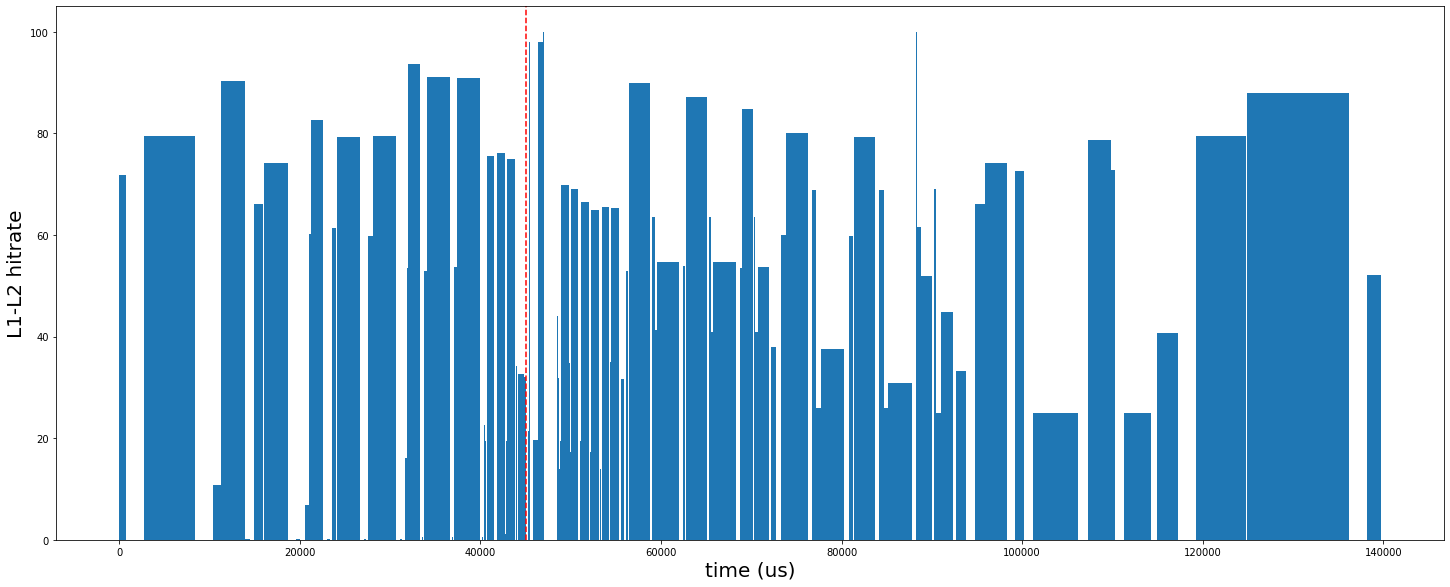

In [17]:
plot_bar(hitrates_time, delimeter=delimeter, ylabel='L1-L2 hitrate', xlabel='time (us)')

In [18]:
get_global_averages(hitrates_time, delimeter)

Average for forward is 54.59313576009049
Average for backward is 50.38865664358518


In [43]:
htr = trans_time*hitrates_time/100

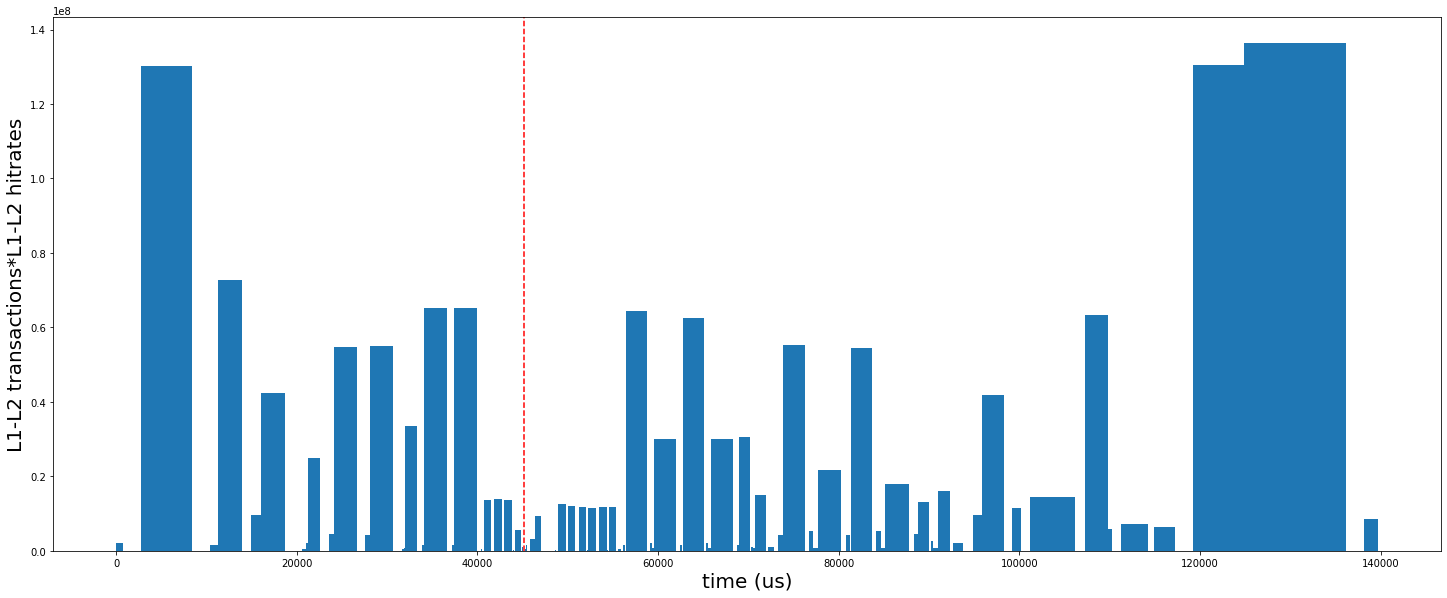

In [20]:
plot_bar(htr, delimeter=delimeter, ylabel='L1-L2 transactions*L1-L2 hitrates', xlabel='time (us)')

In [44]:
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [45]:
def sep(arr, old_delimeter, n=10000):

    f = arr[:old_delimeter]
    b = arr[old_delimeter:]

    f = f[np.logical_not(np.isnan(f))]
    b = b[np.logical_not(np.isnan(b))]

    f_ma = moving_average(f, n)
    b_ma = moving_average(b, n)

    delimeter = len(f_ma)
    out = np.concatenate((f_ma, b_ma))

    return out, delimeter

In [51]:
n = 10000

In [52]:
hitrates_ma, del1 = sep(hitrates_time, delimeter, n)

In [53]:
htr_ma, del2 = sep(htr, delimeter, n)

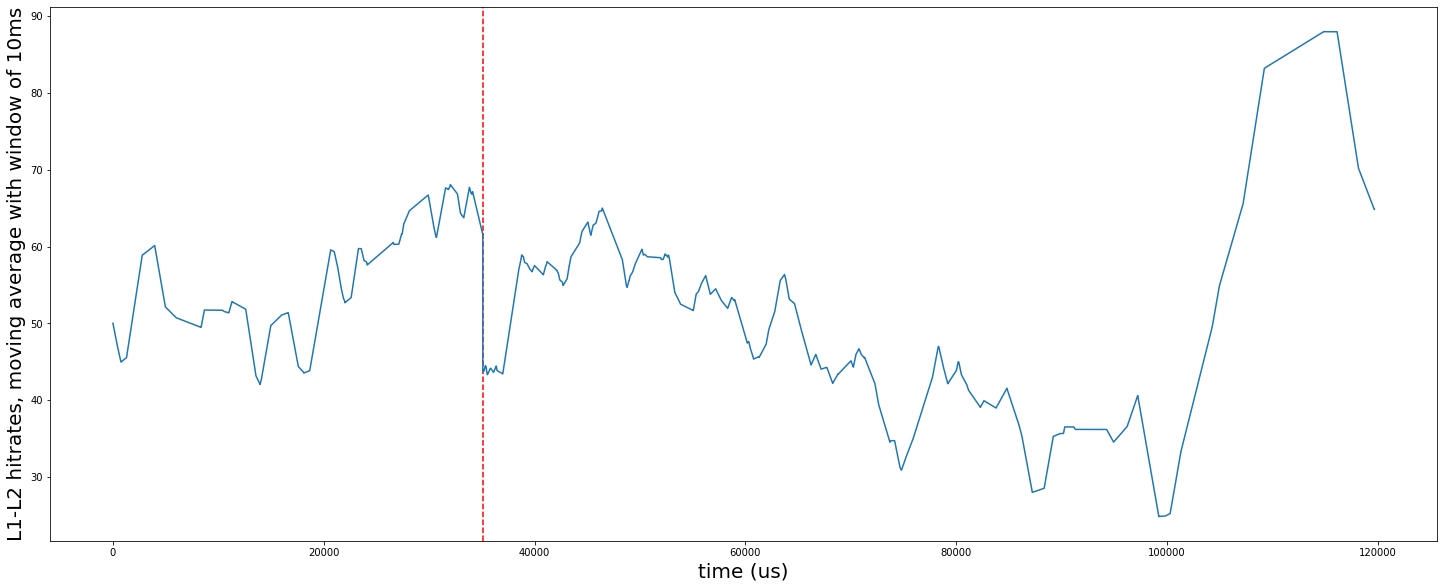

In [54]:
plot_graph(hitrates_ma, delimeter=del1, ylabel='L1-L2 hitrates, moving average with window of 10ms', xlabel='time (us)')

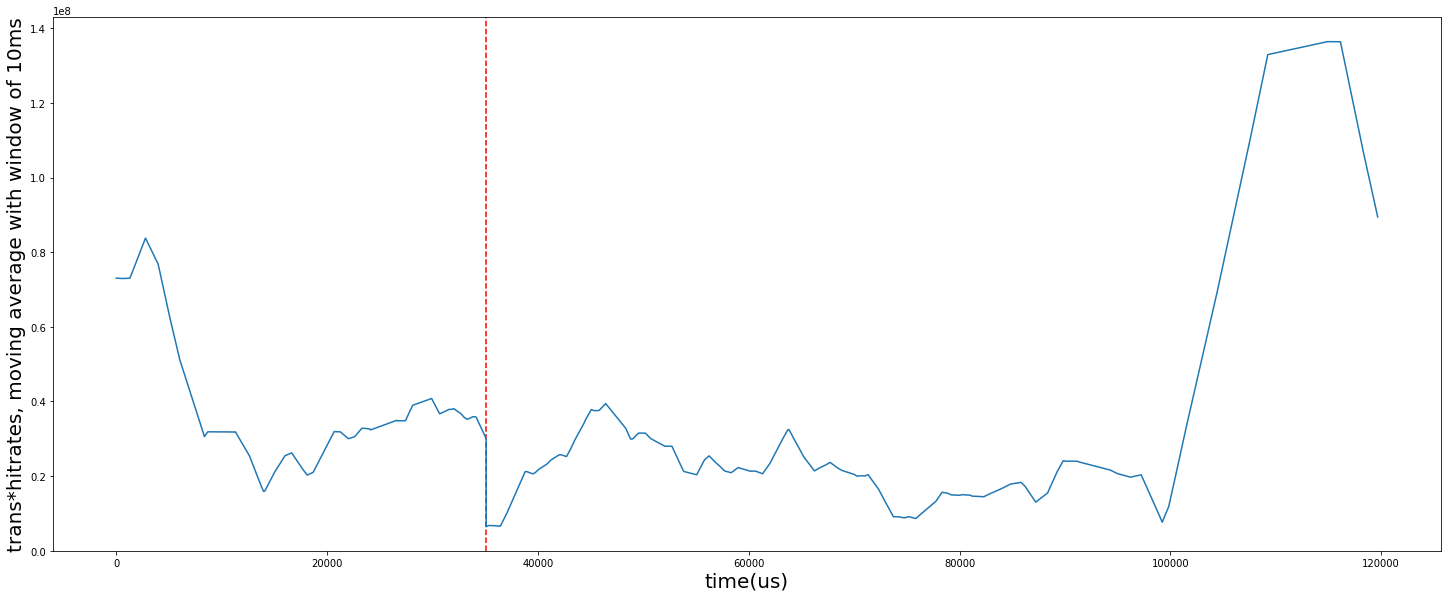

In [55]:
plot_graph(htr_ma, delimeter=del2, ylabel='trans*hitrates, moving average with window of 10ms', xlabel='time(us)')